## Note:
To attempt to run the models with GPU, I used older version for some libraries, namely the tensorflow libiraries (2.4.0), an potentially the gensim library.

In [ ]:
import pandas as pd
import plotly.express as px

In [2]:
# import your libraries here
from typing import List, Dict
from gensim.parsing.preprocessing import stem_text, remove_stopwords, strip_punctuation, strip_non_alphanum
from nltk.tokenize import RegexpTokenizer
from nltk import ngrams
from csv import reader
import string
from pathlib import Path
from collections import Counter
from os import path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from sklearn.manifold import TSNE
%matplotlib inline
from gensim.models import Word2Vec
from multiprocessing import cpu_count
from gensim.models import KeyedVectors
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import os
import re
# import spacy
from gensim.models.phrases import Phrases, Phraser
from time import time 
import multiprocessing
from gensim.models import Word2Vec
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import scale
import tensorflow.keras 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding
from tensorflow.keras.layers import Concatenate
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import confusion_matrix

import re

import warnings
warnings.filterwarnings("ignore")

#### Read Data

In [3]:
df = pd.read_csv("aita_clean.csv").dropna()[["body", "edited", "is_asshole"]]
df.head()

,body,edited,is_asshole
0,[Here is the post in question](http://www.redd...,False,1
1,"My parents are diabetic, morbidly obese, and a...",1393290576.0,1
2,I was four.,False,0
3,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,1393286962.0,1
5,I love the musical *Les Miserables*. A coworke...,False,1


In [4]:
print("length of raw dataset: ", len(df))

length of raw dataset:  97541


In [5]:
df = df[df["body"].apply(lambda x: len(x) > 700)]
df = df[df["edited"] == "False"]
print("length of dataset with short posts and edited post removed: ", len(df))

length of dataset with short posts and edited post removed:  63200


In [6]:
print("num of positive label: ", len(df[df["is_asshole"] == 1]))
print("num of negative label: ", len(df[df["is_asshole"] == 0]))

num of positive label:  15216
num of negative label:  47984


In [7]:
pos = df[df["is_asshole"] == 1]
neg = df[df["is_asshole"] == 0]
# uncomment below to make positive and negative label the same count
neg = neg.sample(len(pos))

In [8]:
df_cleaned = pd.concat([pos, neg])
print("length of dataset with short posts and edited post removed: ", len(df_cleaned))

length of dataset with short posts and edited post removed:  30432


#### Data Augmentation
Use NLPAug library to generate more traning data

In [9]:
# y = df_cleaned.sample(len(df_cleaned) // 5)
# df_cleaned = df_cleaned.drop(y.index)
# print("num of positive label: ", len(y[y["is_asshole"] == 1]))
# print("num of negative label: ", len(y[y["is_asshole"] == 0]))

In [10]:
# df_aug = df_cleaned.copy()
# for index, row in df_cleaned.iterrows():
#     df_aug = df_aug.append({"body": aug.augment(row["body"]), "is_asshole": row["is_asshole"]}, ignore_index = True)

In [11]:
# df_aug["body"] = df_aug["body"].apply(lambda x: x[0] if type(x) == list else x)
# df_aug

#### Preping Data for Traning

In [12]:
def preprocessing(running_lines: List[str]) -> List[List[str]]:
    result = []
    tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')
    for line in running_lines:
        processed = line.lower()
        processed = "".join([char for char in processed if char not in string.punctuation])
        processed = remove_stopwords(processed)
        processed = re.sub(r'[^a-zA-Z0-9 ]', '', processed)
        processed = tokenizer.tokenize(processed)
        temp = []
        for word in processed:
            if len(word) < 16:
                temp.append(word)
        ## if the sentence is not empty
        if temp:
            processed = ["<s>"] + temp + ["</s>"]
            result.append(processed)
    return result

In [13]:
df_cleaned["body"] = preprocessing(list(df_cleaned["body"]))

In [14]:
df_cleaned.head()

,body,edited,is_asshole
5,"[<s>, love, musical, les, miserables, coworker...",False,1
7,"[<s>, im, college, student, roommate, dropped,...",False,1
10,"[<s>, france, summer, friends, eating, peanuts...",False,1
13,"[<s>, im, likely, going, flak, arguing, phone,...",False,1
17,"[<s>, ok, im, type, person, enjoys, quiet, env...",False,1


#### Generate Embeddings with Word2Vec

In [15]:
WORKERS = cpu_count()
MIN_COUNT = 5
WINDOW = 4
SIZE = 30
# SAMPLE = 6e-5
# ALPHA = 0.03
# MIN_ALPHA = 0.0007
# NEGATIVE = 20

w2v = Word2Vec(
    min_count = MIN_COUNT,
    window = WINDOW,
    vector_size = SIZE,
#     alpha = ALPHA,
#     sample = SAMPLE,
#     min_alpha = MIN_ALPHA,
#     negative = NEGATIVE,
    workers = WORKERS)

# t = time()
# w2v.build_vocab(df_cleaned["body"], progress_per=1000)
# print('Time to build vocab: {} seconds'.format(round((time() - t), 2)))

# w2v.train(df_cleaned["body"], total_examples=w2v.corpus_count, epochs=500, report_delay=1)
# print('Time to train the model: {} seconds'.format(round((time() - t), 2)))

w2v = Word2Vec.load("aita/aita.model")

In [16]:
# saving the w2v model
# w2v.save("aita/aita.model")

In [17]:
# defining the chart
output_notebook()
plot_tfidf = bp.figure(outer_width = 600, outer_height = 600, title = "Distribution of 10000 Sample of Word Vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover",
    x_axis_type = None, y_axis_type = None, min_border = 1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [w2v.wv[w] for w in list(w2v.wv.index_to_key)[:5000]]

# dimensionality reduction. converting the vectors to 2d vectors
tsne_model = TSNE(n_components = 2, verbose = 0, random_state = 0)
tsne_w2v = tsne_model.fit_transform(np.array(word_vectors))

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns = ['x', 'y'])
tsne_df['words'] = list(w2v.wv.index_to_key)[:5000]

# making tooltips
plot_tfidf.scatter(x = 'x', y = 'y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

In [18]:
# train test split
y = df_cleaned['is_asshole'].values
X = np.array(df_cleaned["body"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

#### Augmentation Train Test Split
The augmented dataset, when used in the project, underwent a different train-test split procedure to prevent the testing data from getting augmented

In [19]:
# y["body"] = preprocessing(list(y["body"]))

In [20]:
# X_train = np.array(df_aug["body"])
# y_train = df_aug['is_asshole'].values

# X_test = np.array(y["body"])
# y_test = y['is_asshole'].values

#### Vectorization

In [21]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

vocab size : 12625


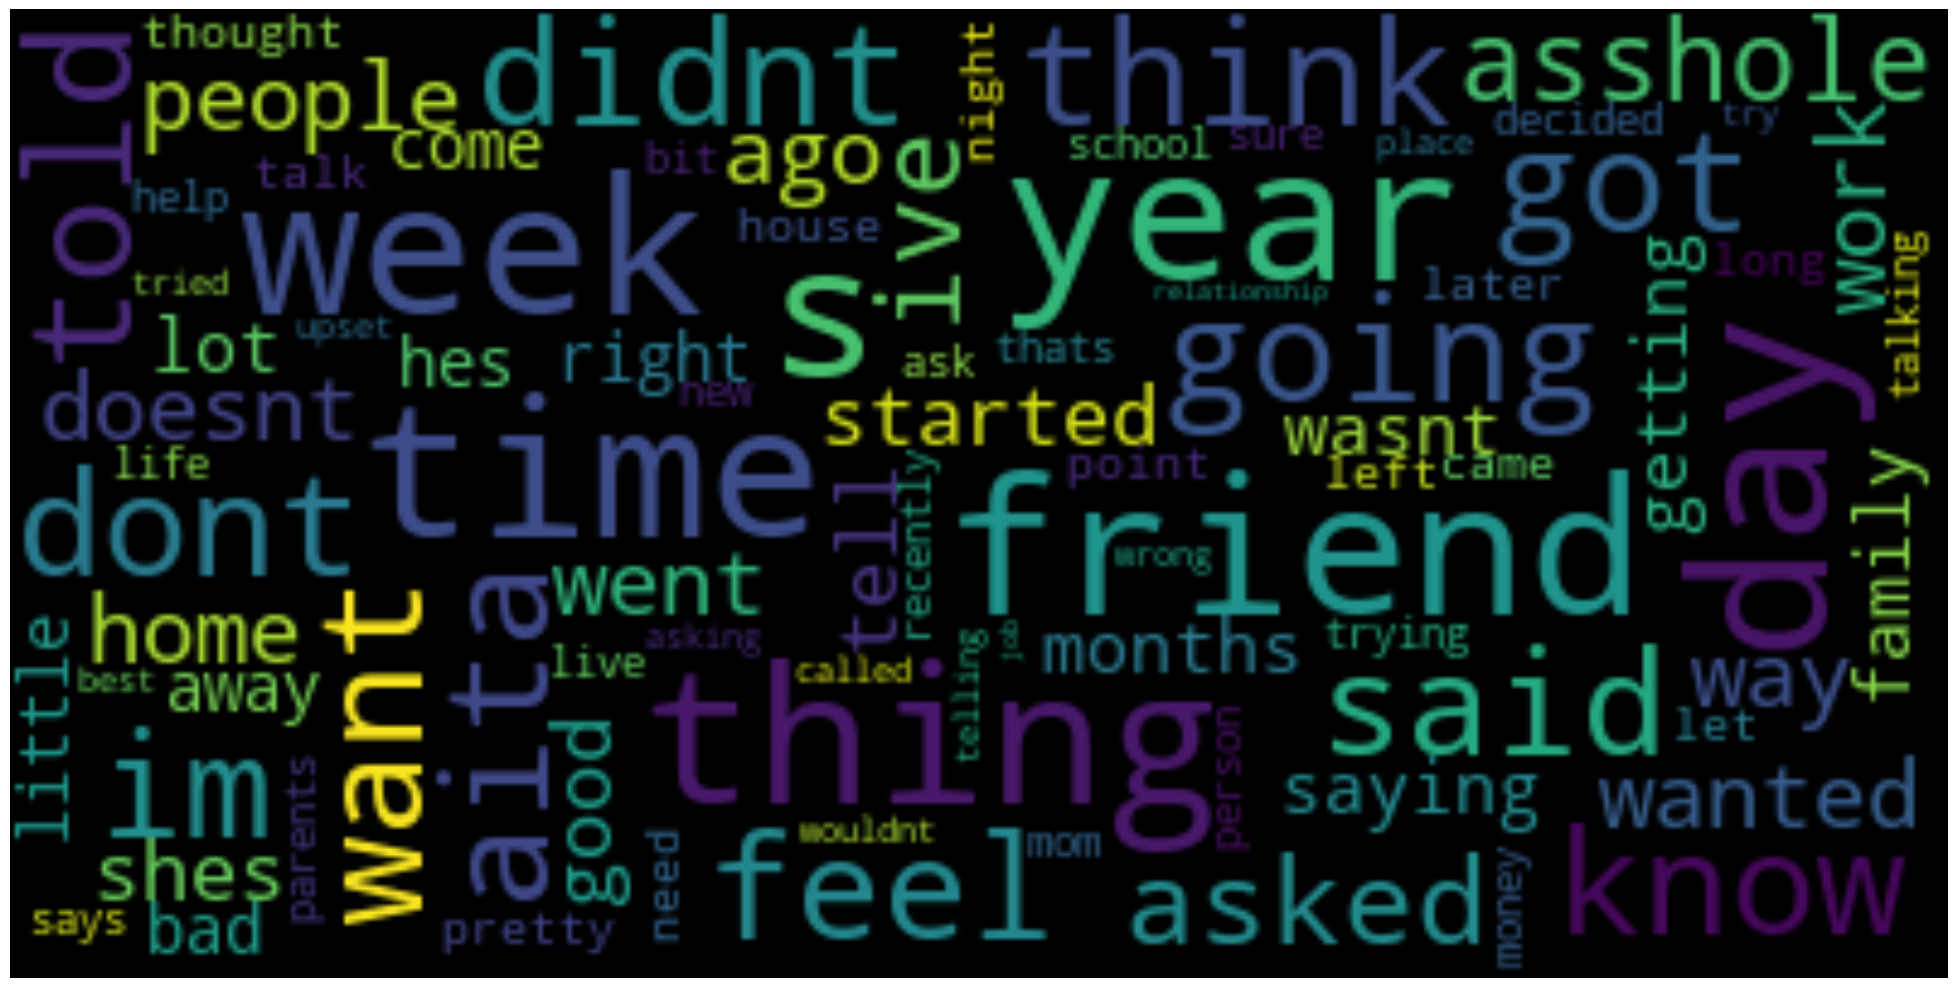

In [22]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
tfidf2 = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf2.columns = ['tfidf']
plot_word_cloud(tfidf2.sort_values(by=['tfidf'], ascending=True).head(100))

In [23]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v.wv[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [24]:
train_vecs_w2v = np.concatenate([buildWordVector(z, SIZE) for z in map(lambda x: x, X_train)])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, SIZE) for z in map(lambda x: x, X_test)])
test_vecs_w2v = scale(test_vecs_w2v)

print ('shape for training set : ',train_vecs_w2v.shape,
      '\nshape for test set : ', test_vecs_w2v.shape)

shape for training set :  (25867, 30) 
shape for test set :  (4565, 30)


#### Logistic Regression from Scikit-learn

In [25]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1, penalty = "l2").fit(train_vecs_w2v, y_train)

In [26]:
lr.score(test_vecs_w2v, y_test)

0.5575027382256298

In [27]:
lr_pred = lr.predict(test_vecs_w2v)
confusion_matrix(lr_pred, y_test)

array([[1307, 1070],
       [ 950, 1238]], dtype=int64)

#### Random Forest Classifier from scikit-learn

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
rf = RandomForestClassifier(max_depth=10, random_state=2)
rf.fit(train_vecs_w2v, y_train)

RandomForestClassifier(max_depth=10, random_state=2)

In [29]:
rf.score(test_vecs_w2v, y_test)

0.5627601314348303

In [30]:
rf_pred = rf.predict(test_vecs_w2v)
confusion_matrix(rf_pred, y_test)

array([[1271, 1010],
       [ 986, 1298]], dtype=int64)

#### Feed Forward Neural Network

In [31]:
model = Sequential()

model.add(Dense(256, activation='relu', input_dim=SIZE))
model.add(Dense(128, activation='relu', input_dim=SIZE))
model.add(Dense(128, activation='relu', input_dim=SIZE))
model.add(Dense(128, activation='relu', input_dim=SIZE))
model.add(Dense(3, kernel_regularizer='l2'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7936      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4

In [32]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

2.4.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [33]:
history = model.fit(train_vecs_w2v, y_train, epochs=1000, batch_size=30,
                   validation_data=(test_vecs_w2v,y_test))
loss, accuracy = model.evaluate(train_vecs_w2v, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_vecs_w2v, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/1000
863/863 [==============================] - 3s 3ms/step - loss: 5.1666 - accuracy: 0.4987 - val_loss: 5.7797 - val_accuracy: 0.4944
Epoch 2/1000
863/863 [==============================] - 1s 1ms/step - loss: 4.7219 - accuracy: 0.5006 - val_loss: 5.0137 - val_accuracy: 0.4944
Epoch 3/1000
863/863 [==============================] - 1s 1ms/step - loss: 4.3033 - accuracy: 0.4988 - val_loss: 4.2334 - val_accuracy: 0.4944
Epoch 4/1000
863/863 [==============================] - 1s 2ms/step - loss: 3.8054 - accuracy: 0.5016 - val_loss: 3.4655 - val_accuracy: 0.4949
Epoch 5/1000
863/863 [==============================] - 1s 2ms/step - loss: 3.5158 - accuracy: 0.4968 - val_loss: 2.8601 - val_accuracy: 0.4949
Epoch 6/1000
863/863 [==============================] - 1s 2ms/step - loss: 3.1891 - accuracy: 0.4903 - val_loss: 2.2360 - val_accuracy: 0.4949
Epoch 7/1000
863/863 [==============================] - 1s 2ms/step - loss: 2.8103 - accuracy: 0.5011 - val_loss: 1.7513 - val_accuracy:

863/863 [==============================] - 1s 1ms/step - loss: 1.1092 - accuracy: 0.5111 - val_loss: 0.8003 - val_accuracy: 0.5179
Epoch 58/1000
863/863 [==============================] - 1s 1ms/step - loss: 1.0751 - accuracy: 0.5188 - val_loss: 0.7996 - val_accuracy: 0.5183
Epoch 59/1000
863/863 [==============================] - 1s 1ms/step - loss: 1.0814 - accuracy: 0.5124 - val_loss: 0.7988 - val_accuracy: 0.5181
Epoch 60/1000
863/863 [==============================] - 1s 1ms/step - loss: 1.0872 - accuracy: 0.5128 - val_loss: 0.7970 - val_accuracy: 0.5181
Epoch 61/1000
863/863 [==============================] - 1s 1ms/step - loss: 1.0792 - accuracy: 0.5148 - val_loss: 0.7968 - val_accuracy: 0.5189
Epoch 62/1000
863/863 [==============================] - 1s 1ms/step - loss: 1.0887 - accuracy: 0.5094 - val_loss: 0.7977 - val_accuracy: 0.5179
Epoch 63/1000
863/863 [==============================] - 1s 1ms/step - loss: 1.0819 - accuracy: 0.5041 - val_loss: 0.7978 - val_accuracy: 0.5176

863/863 [==============================] - 1s 2ms/step - loss: 0.9617 - accuracy: 0.5142 - val_loss: 0.7795 - val_accuracy: 0.5220
Epoch 114/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.9709 - accuracy: 0.5157 - val_loss: 0.7796 - val_accuracy: 0.5211
Epoch 115/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.9694 - accuracy: 0.5170 - val_loss: 0.7806 - val_accuracy: 0.5194
Epoch 116/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.9520 - accuracy: 0.5136 - val_loss: 0.7792 - val_accuracy: 0.5205
Epoch 117/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.9642 - accuracy: 0.5203 - val_loss: 0.7786 - val_accuracy: 0.5207
Epoch 118/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.9467 - accuracy: 0.5232 - val_loss: 0.7792 - val_accuracy: 0.5198
Epoch 119/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.9388 - accuracy: 0.5207 - val_loss: 0.7785 - val_accuracy: 

863/863 [==============================] - 1s 2ms/step - loss: 0.8935 - accuracy: 0.5279 - val_loss: 0.7674 - val_accuracy: 0.5189
Epoch 170/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.9014 - accuracy: 0.5199 - val_loss: 0.7671 - val_accuracy: 0.5192
Epoch 171/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.8871 - accuracy: 0.5281 - val_loss: 0.7674 - val_accuracy: 0.5187
Epoch 172/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.8892 - accuracy: 0.5234 - val_loss: 0.7667 - val_accuracy: 0.5189
Epoch 173/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.8918 - accuracy: 0.5187 - val_loss: 0.7663 - val_accuracy: 0.5198
Epoch 174/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.8789 - accuracy: 0.5295 - val_loss: 0.7656 - val_accuracy: 0.5200
Epoch 175/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.8667 - accuracy: 0.5345 - val_loss: 0.7656 - val_accuracy: 

863/863 [==============================] - 1s 1ms/step - loss: 0.8397 - accuracy: 0.5385 - val_loss: 0.7561 - val_accuracy: 0.5249
Epoch 226/1000
863/863 [==============================] - 2s 2ms/step - loss: 0.8523 - accuracy: 0.5225 - val_loss: 0.7570 - val_accuracy: 0.5231
Epoch 227/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.8397 - accuracy: 0.5287 - val_loss: 0.7572 - val_accuracy: 0.5235
Epoch 228/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.8311 - accuracy: 0.5358 - val_loss: 0.7567 - val_accuracy: 0.5235
Epoch 229/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.8344 - accuracy: 0.5278 - val_loss: 0.7559 - val_accuracy: 0.5246
Epoch 230/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.8363 - accuracy: 0.5306 - val_loss: 0.7559 - val_accuracy: 0.5240
Epoch 231/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.8319 - accuracy: 0.5303 - val_loss: 0.7558 - val_accuracy: 

863/863 [==============================] - 1s 2ms/step - loss: 0.8057 - accuracy: 0.5330 - val_loss: 0.7469 - val_accuracy: 0.5288
Epoch 282/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.8060 - accuracy: 0.5378 - val_loss: 0.7473 - val_accuracy: 0.5273
Epoch 283/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.8029 - accuracy: 0.5405 - val_loss: 0.7470 - val_accuracy: 0.5279
Epoch 284/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7994 - accuracy: 0.5406 - val_loss: 0.7464 - val_accuracy: 0.5286
Epoch 285/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7911 - accuracy: 0.5437 - val_loss: 0.7452 - val_accuracy: 0.5286
Epoch 286/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7977 - accuracy: 0.5417 - val_loss: 0.7447 - val_accuracy: 0.5297
Epoch 287/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.7982 - accuracy: 0.5417 - val_loss: 0.7447 - val_accuracy: 

863/863 [==============================] - 1s 2ms/step - loss: 0.7841 - accuracy: 0.5403 - val_loss: 0.7379 - val_accuracy: 0.5308
Epoch 338/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.7822 - accuracy: 0.5438 - val_loss: 0.7388 - val_accuracy: 0.5297
Epoch 339/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.7786 - accuracy: 0.5445 - val_loss: 0.7386 - val_accuracy: 0.5297
Epoch 340/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7791 - accuracy: 0.5468 - val_loss: 0.7382 - val_accuracy: 0.5303
Epoch 341/1000
863/863 [==============================] - 2s 2ms/step - loss: 0.7776 - accuracy: 0.5447 - val_loss: 0.7379 - val_accuracy: 0.5303
Epoch 342/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7754 - accuracy: 0.5443 - val_loss: 0.7381 - val_accuracy: 0.5299
Epoch 343/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.7787 - accuracy: 0.5419 - val_loss: 0.7373 - val_accuracy: 

863/863 [==============================] - 1s 1ms/step - loss: 0.7559 - accuracy: 0.5487 - val_loss: 0.7311 - val_accuracy: 0.5358
Epoch 394/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7573 - accuracy: 0.5477 - val_loss: 0.7314 - val_accuracy: 0.5343
Epoch 395/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7644 - accuracy: 0.5445 - val_loss: 0.7315 - val_accuracy: 0.5341
Epoch 396/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7552 - accuracy: 0.5511 - val_loss: 0.7311 - val_accuracy: 0.5363
Epoch 397/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7567 - accuracy: 0.5527 - val_loss: 0.7306 - val_accuracy: 0.5373
Epoch 398/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.7596 - accuracy: 0.5444 - val_loss: 0.7302 - val_accuracy: 0.5371
Epoch 399/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7580 - accuracy: 0.5486 - val_loss: 0.7304 - val_accuracy: 

863/863 [==============================] - 1s 2ms/step - loss: 0.7375 - accuracy: 0.5638 - val_loss: 0.7259 - val_accuracy: 0.5441
Epoch 450/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.7424 - accuracy: 0.5540 - val_loss: 0.7261 - val_accuracy: 0.5415
Epoch 451/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.7409 - accuracy: 0.5557 - val_loss: 0.7260 - val_accuracy: 0.5424
Epoch 452/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.7392 - accuracy: 0.5610 - val_loss: 0.7261 - val_accuracy: 0.5417
Epoch 453/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.7337 - accuracy: 0.5606 - val_loss: 0.7257 - val_accuracy: 0.5428
Epoch 454/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7474 - accuracy: 0.5560 - val_loss: 0.7258 - val_accuracy: 0.5424
Epoch 455/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7400 - accuracy: 0.5535 - val_loss: 0.7258 - val_accuracy: 

863/863 [==============================] - 1s 1ms/step - loss: 0.7320 - accuracy: 0.5604 - val_loss: 0.7222 - val_accuracy: 0.5441
Epoch 506/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7241 - accuracy: 0.5699 - val_loss: 0.7221 - val_accuracy: 0.5437
Epoch 507/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7339 - accuracy: 0.5591 - val_loss: 0.7218 - val_accuracy: 0.5463
Epoch 508/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7266 - accuracy: 0.5687 - val_loss: 0.7216 - val_accuracy: 0.5468
Epoch 509/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7248 - accuracy: 0.5626 - val_loss: 0.7215 - val_accuracy: 0.5474
Epoch 510/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7247 - accuracy: 0.5719 - val_loss: 0.7214 - val_accuracy: 0.5483
Epoch 511/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7266 - accuracy: 0.5593 - val_loss: 0.7215 - val_accuracy: 

863/863 [==============================] - 1s 1ms/step - loss: 0.7166 - accuracy: 0.5711 - val_loss: 0.7184 - val_accuracy: 0.5472
Epoch 562/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7213 - accuracy: 0.5670 - val_loss: 0.7180 - val_accuracy: 0.5483
Epoch 563/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7189 - accuracy: 0.5667 - val_loss: 0.7180 - val_accuracy: 0.5479
Epoch 564/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7164 - accuracy: 0.5728 - val_loss: 0.7183 - val_accuracy: 0.5465
Epoch 565/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7216 - accuracy: 0.5631 - val_loss: 0.7184 - val_accuracy: 0.5468
Epoch 566/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7216 - accuracy: 0.5666 - val_loss: 0.7181 - val_accuracy: 0.5465
Epoch 567/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7155 - accuracy: 0.5668 - val_loss: 0.7179 - val_accuracy: 

863/863 [==============================] - 1s 1ms/step - loss: 0.7107 - accuracy: 0.5748 - val_loss: 0.7151 - val_accuracy: 0.5476
Epoch 618/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7065 - accuracy: 0.5808 - val_loss: 0.7154 - val_accuracy: 0.5474
Epoch 619/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7058 - accuracy: 0.5778 - val_loss: 0.7150 - val_accuracy: 0.5485
Epoch 620/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7076 - accuracy: 0.5741 - val_loss: 0.7152 - val_accuracy: 0.5474
Epoch 621/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7061 - accuracy: 0.5787 - val_loss: 0.7151 - val_accuracy: 0.5474
Epoch 622/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7083 - accuracy: 0.5794 - val_loss: 0.7150 - val_accuracy: 0.5481
Epoch 623/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7116 - accuracy: 0.5750 - val_loss: 0.7153 - val_accuracy: 

863/863 [==============================] - 1s 1ms/step - loss: 0.7014 - accuracy: 0.5856 - val_loss: 0.7130 - val_accuracy: 0.5512
Epoch 674/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6995 - accuracy: 0.5799 - val_loss: 0.7128 - val_accuracy: 0.5505
Epoch 675/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6998 - accuracy: 0.5874 - val_loss: 0.7129 - val_accuracy: 0.5509
Epoch 676/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7088 - accuracy: 0.5747 - val_loss: 0.7131 - val_accuracy: 0.5518
Epoch 677/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7020 - accuracy: 0.5818 - val_loss: 0.7129 - val_accuracy: 0.5514
Epoch 678/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7019 - accuracy: 0.5821 - val_loss: 0.7125 - val_accuracy: 0.5507
Epoch 679/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.7019 - accuracy: 0.5787 - val_loss: 0.7126 - val_accuracy: 

863/863 [==============================] - 1s 1ms/step - loss: 0.6995 - accuracy: 0.5835 - val_loss: 0.7111 - val_accuracy: 0.5531
Epoch 730/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6940 - accuracy: 0.5886 - val_loss: 0.7104 - val_accuracy: 0.5551
Epoch 731/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6952 - accuracy: 0.5868 - val_loss: 0.7107 - val_accuracy: 0.5551
Epoch 732/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6978 - accuracy: 0.5916 - val_loss: 0.7108 - val_accuracy: 0.5533
Epoch 733/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6951 - accuracy: 0.5872 - val_loss: 0.7107 - val_accuracy: 0.5529
Epoch 734/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6948 - accuracy: 0.5832 - val_loss: 0.7108 - val_accuracy: 0.5514
Epoch 735/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6946 - accuracy: 0.5860 - val_loss: 0.7108 - val_accuracy: 

863/863 [==============================] - 1s 1ms/step - loss: 0.6914 - accuracy: 0.5906 - val_loss: 0.7093 - val_accuracy: 0.5577
Epoch 786/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6916 - accuracy: 0.5933 - val_loss: 0.7094 - val_accuracy: 0.5564
Epoch 787/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6905 - accuracy: 0.5882 - val_loss: 0.7094 - val_accuracy: 0.5555
Epoch 788/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6889 - accuracy: 0.5888 - val_loss: 0.7095 - val_accuracy: 0.5562
Epoch 789/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6898 - accuracy: 0.5932 - val_loss: 0.7097 - val_accuracy: 0.5573
Epoch 790/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6923 - accuracy: 0.5896 - val_loss: 0.7092 - val_accuracy: 0.5562
Epoch 791/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6862 - accuracy: 0.5991 - val_loss: 0.7094 - val_accuracy: 

863/863 [==============================] - 1s 1ms/step - loss: 0.6824 - accuracy: 0.5989 - val_loss: 0.7086 - val_accuracy: 0.5575
Epoch 842/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6875 - accuracy: 0.6027 - val_loss: 0.7086 - val_accuracy: 0.5571
Epoch 843/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6878 - accuracy: 0.5991 - val_loss: 0.7085 - val_accuracy: 0.5564
Epoch 844/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6808 - accuracy: 0.6036 - val_loss: 0.7082 - val_accuracy: 0.5584
Epoch 845/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6868 - accuracy: 0.5956 - val_loss: 0.7085 - val_accuracy: 0.5571
Epoch 846/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6849 - accuracy: 0.6048 - val_loss: 0.7084 - val_accuracy: 0.5575
Epoch 847/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6793 - accuracy: 0.5973 - val_loss: 0.7084 - val_accuracy: 

863/863 [==============================] - 1s 1ms/step - loss: 0.6789 - accuracy: 0.6055 - val_loss: 0.7077 - val_accuracy: 0.5590
Epoch 898/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6777 - accuracy: 0.6052 - val_loss: 0.7078 - val_accuracy: 0.5593
Epoch 899/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6820 - accuracy: 0.6100 - val_loss: 0.7079 - val_accuracy: 0.5582
Epoch 900/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6773 - accuracy: 0.6089 - val_loss: 0.7076 - val_accuracy: 0.5584
Epoch 901/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6792 - accuracy: 0.6146 - val_loss: 0.7076 - val_accuracy: 0.5601
Epoch 902/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.6734 - accuracy: 0.6178 - val_loss: 0.7075 - val_accuracy: 0.5593
Epoch 903/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6804 - accuracy: 0.6060 - val_loss: 0.7075 - val_accuracy: 

863/863 [==============================] - 1s 1ms/step - loss: 0.6738 - accuracy: 0.6169 - val_loss: 0.7072 - val_accuracy: 0.5632
Epoch 954/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6739 - accuracy: 0.6088 - val_loss: 0.7074 - val_accuracy: 0.5617
Epoch 955/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.6794 - accuracy: 0.6083 - val_loss: 0.7074 - val_accuracy: 0.5621
Epoch 956/1000
863/863 [==============================] - 1s 1ms/step - loss: 0.6753 - accuracy: 0.6122 - val_loss: 0.7071 - val_accuracy: 0.5625
Epoch 957/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.6784 - accuracy: 0.6064 - val_loss: 0.7074 - val_accuracy: 0.5623
Epoch 958/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.6733 - accuracy: 0.6091 - val_loss: 0.7074 - val_accuracy: 0.5617
Epoch 959/1000
863/863 [==============================] - 1s 2ms/step - loss: 0.6772 - accuracy: 0.6134 - val_loss: 0.7073 - val_accuracy: 

In [34]:
ff_pred = model.predict(test_vecs_w2v)
ff_pred = [0 if x < 0.5 else 1 for x in ff_pred]
confusion_matrix(ff_pred, y_test)

array([[1475, 1219],
       [ 782, 1089]], dtype=int64)

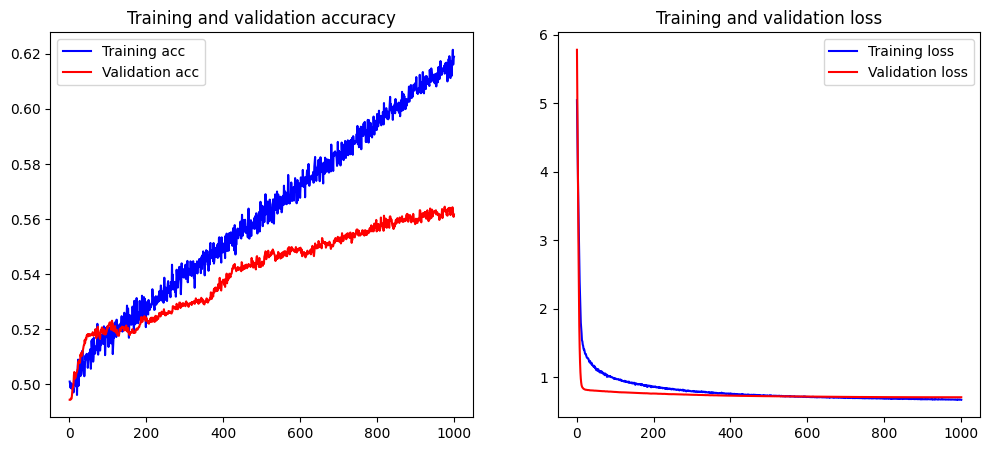

In [35]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

#### CNN

In [36]:
all_words = [word for tokens in X for word in tokens]
all_sentence_lengths = [len(tokens) for tokens in X]
all_vocab = sorted(list(set(all_words)))


# hyperparameters
EMBEDDING_DIM = SIZE
MAX_VOCAB_SIZE = len(w2v.wv)
MAX_SEQUENCE_LENGTH = 500


tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(df_cleaned["body"].tolist())
training_sequences = tokenizer.texts_to_sequences(X_train.tolist())
train_word_index = tokenizer.word_index
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))

for word,index in train_word_index.items():
    train_embedding_weights[index,:] = w2v.wv[word] if word in w2v.wv else np.random.rand(EMBEDDING_DIM)
    
print(train_embedding_weights.shape)


train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_sequences = tokenizer.texts_to_sequences(X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

(67132, 30)


In [37]:
from tensorflow.keras.layers import concatenate
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = concatenate([convs[0],convs[1],convs[2]],axis=1)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    # Finally, we feed the output into a Sigmoid layer.
    # The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) 
    # for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.
    preds = Dense(1,activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    model.summary()
    return model

In [38]:
convNet = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 30)      2013960     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 498, 128)     11648       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 497, 128)     15488       embedding[0][0]                  
______________________________________________________________________________________________

In [39]:
historyConvNet = convNet.fit(train_cnn_data, y_train, epochs=20, batch_size=50, validation_data=(test_cnn_data,y_test))
loss, accuracy = convNet.evaluate(train_cnn_data, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = convNet.evaluate(test_cnn_data, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
518/518 [==============================] - 56s 107ms/step - loss: 0.9584 - accuracy: 0.4998 - val_loss: 0.7462 - val_accuracy: 0.5062
Epoch 2/20
518/518 [==============================] - 56s 108ms/step - loss: 0.8225 - accuracy: 0.5109 - val_loss: 0.7101 - val_accuracy: 0.5183
Epoch 3/20
518/518 [==============================] - 54s 105ms/step - loss: 0.7577 - accuracy: 0.5135 - val_loss: 0.6958 - val_accuracy: 0.5146
Epoch 4/20
518/518 [==============================] - 56s 108ms/step - loss: 0.7237 - accuracy: 0.5247 - val_loss: 0.6928 - val_accuracy: 0.5154
Epoch 5/20
518/518 [==============================] - 56s 108ms/step - loss: 0.7078 - accuracy: 0.5234 - val_loss: 0.6917 - val_accuracy: 0.5271
Epoch 6/20
518/518 [==============================] - 55s 106ms/step - loss: 0.7001 - accuracy: 0.5246 - val_loss: 0.6912 - val_accuracy: 0.5323
Epoch 7/20
518/518 [==============================] - 55s 107ms/step - loss: 0.6955 - accuracy: 0.5242 - val_loss: 0.6903 - val_ac

In [40]:
cnn_pred = convNet.predict(test_cnn_data)
cnn_pred = [0 if x < 0.5 else 1 for x in cnn_pred]
confusion_matrix(cnn_pred, y_test)

array([[ 998,  793],
       [1259, 1515]], dtype=int64)